In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
import pandas as pd
from scipy.interpolate import griddata


In [2]:
# Default plot parameters
font = {'weight' : 'normal',
        'size'   : 20}

rc('font', **font)
legend_fs = 16

N = 5
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.gnuplot2(np.linspace(0,1,N)))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['image.cmap'] = 'inferno'
cmap = cm.get_cmap('inferno')


C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\3302853007.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('inferno')


In [3]:
# Data directories 
folderA = "Raw_data/profilometry_waferA"
folderB = "Raw_data/profilometry_waferB"

# Masses applied with the stylus (mg)
forces_waferA = np.arange(1, 16, 1) 
forces_waferB = np.arange(1, 16, 2)        

# Convert to force (muN)
forces_newtons_waferA = 9.8*forces_waferA   
forces_newtons_waferB = 9.8*forces_waferB  

# Membrane indices
mem_idx = [11, 12, 13, 21, 22, 23, 31, 32, 33]
wrong_idx = [11, 12, 13, 21, 22, 23, 11, 12, 13]    # mislabeled data
data = []
peaks = []

def colormap_range(widths, width, cmap):
    return cmap(int((width-np.min(widths))/(np.max(widths)-np.min(widths)) * 255))

def center_profile(data):
    """
    Centers linescan at the midpoint between membrane edges (where membrane starts to bend)
    """
    y = 1e-4*np.abs(data.iloc[:,1])         # Convert from Angstrom to um 
    y_neg = np.where(y>0.10*np.max(y))[0]   # Find all points where surface is bent
    x_shift = (data.iloc[int(y_neg[-1]),0] + data.iloc[int(y_neg[0]),0]) / 2    # x-shift necessary to center profile
    data.iloc[:,0] -= float(x_shift)

    return data, x_shift

def process_profile_data(folder, mem_idxs, forces, rev_format=False):
    """
    Extracts all relevant information from the (forward & reverse) profilometry scans including: 
        - Maximum deflections max(\phi)
        - Membrane widths w_b

    Arguments: 
        - mem_idxs :    membrane indices (array)
        - forces :      forces applied to the membranes in muN (array)
    """
    
    result = {}
    rev_idxs = [1, 5, 10]
    for jj, idx in enumerate(mem_idxs):
        result[f"Mem {jj}"] = {
            "Data" : {"Forward" : [], "Reverse": []}, 
            "Peaks" : {"Forward" : [], "Reverse": []},
            "Widths" : {"Forward" : [], "Reverse": []}, 
            }
        for ii, n in enumerate(forces):
            filename = folder + "\%i\%i_%img.csv" % (mem_idx[jj],idx,n)
            result[f"Mem {jj}"]["Data"]["Forward"].append(pd.read_csv(filename, skiprows=23))
            data = result[f"Mem {jj}"]["Data"]["Forward"][ii]
            if ii==0: 
                _ , data_optimum = center_profile(data)     # Only calculate centering shift once per membrane
            else:
                data.iloc[:,0] = data.iloc[:,0] - data_optimum
            result[f"Mem {jj}"]["Peaks"]["Forward"].append(np.max(-data.iloc[:,1]))

        for kk, rev_idx in enumerate(rev_idxs):
            if rev_format:   # Slightly different file naming conventions between wafers
                # Wafer A
                filename = folder + "\%i\%i_rev_%img.csv" % (mem_idx[jj],idx,rev_idx)
            else:
                # Wafer B
                filename = folder + "\%i\%i_%img_r.csv" % (mem_idx[jj],idx,rev_idx)

            result[f"Mem {jj}"]["Data"]["Reverse"].append(pd.read_csv(filename, skiprows=23))
            data = result[f"Mem {jj}"]["Data"]["Reverse"][kk]
            data.iloc[:,0] = data.iloc[:,0] - data_optimum
        
        # Calculate membrane width similar to how centering shift is applied
        x_pos = np.array(result[f"Mem {jj}"]["Data"]["Forward"][-1].iloc[:,0])
        y = 1e-4*result[f"Mem {jj}"]["Data"]["Forward"][-1].iloc[:,1]
        y_neg = np.where(y<-5e-3)[0]
        result[f"Mem {jj}"]["Widths"]["Forward"].append(
            x_pos[y_neg[-1]] - x_pos[y_neg[0]]
        )

    return result

result_waferA = process_profile_data(folderA, wrong_idx, forces_waferA, rev_format=True)
result_waferB = process_profile_data(folderB, mem_idx, forces_waferB, rev_format=False)


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\%'
<>:65: SyntaxWarning: invalid escape sequence '\%'
<>:68: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\%'
<>:65: SyntaxWarning: invalid escape sequence '\%'
<>:68: SyntaxWarning: invalid escape sequence '\%'
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\3182302177.py:2: SyntaxWarning: invalid escape sequence '\p'
  folderA = "Raw_data\profilometry_waferA"
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\3182302177.py:3: SyntaxWarning: invalid escape sequence '\p'
  folderB = "Raw_data\profilometry_waferB"
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\3182302177.py:36: SyntaxWarning: i

In [4]:
def symmetrize_array(arr, sign_flip=True):
    """ 
    Appends a flipped copy of the array "arr" of length n to symmetrize the returned "sym_arr" of length 2n.
    """
    sym_arr = list((-1)**int(sign_flip) * np.flip(arr[1::])) + list(arr)
    return sym_arr

def sim_mem_profile(sim_path, filesuffix, exp_data, force, forces_arr, fig, axs, cnt=0):
    """
    Extracts and plots the finite element method (FEM) and Kirchhoff-Love (KL) simulation results together
    with experimental data. 

    Note: FEM simulations contain full profile of membrane for a given stylus position and force. 
    We are interested in the maximum deflection of the membrane at each position of the stylus 
    (assuming no built-in curvature at 0 load). We need only to do this for one half of the membrane 
    since the FEM solution is symmetric (hence the symmmetrize_array() function).

    Arguments: 
        sim_path :      array of directory paths to the FEM data for different stylus positions
        filesuffix :    array of strings to aid in referencing individual data files
        exp_data :      dict of extracted profilometry data
        force :         simulated force applied by stylus (in mg)
        forces_arr :    array of all experimentally applied forces (in mg)
        fig :           figure handle
        axs :           axes handle
        cnt :           force index for legend
    """

    num_scans = 10
    styPos = np.arange(0,100,10)        # stylus positions (um)
    styPos = np.array([float(ii) for ii in symmetrize_array(styPos)])

    # Extract FEM data and determine maximum membrane deflection for each stylus position
    max_disp = []
    max_disp_arg = []
    for ii in range(num_scans):
        filename = f"\cutline{filesuffix}{ii}0.txt"
        data = np.genfromtxt(sim_path + filename, skip_header=9)
        x = np.sqrt(2)*data[:,0]
        z = data[:,2]
        max_disp.append(np.min(z))
        max_disp_arg.append(x[np.where(z==np.min(z))])
    
    # Only use experimental data for force passed to function
    ii = np.where(forces_arr==force)[0][0]      
    profiles = []
    x = np.linspace(-100,100,1000)
    for kk, key in enumerate(exp_data.keys()):
        data = exp_data[key]["Data"]["Forward"][ii]
        _ , data_optimum = center_profile(data)
        # Omit membranes which are clearly much larger in width that the rest
        if kk==2 or kk==8: continue 
        profiles.append(
            # Interpolate for averaging
            np.interp(x, data.iloc[:,0], data.iloc[:,1])    
        )
    averaged_profile = 1e-4*np.mean(profiles, axis=0)   # Converted to um
    averaged_profile_err = 1e-4*np.std(profiles, axis=0)
    x_offset = 300*cnt + 100        # Offset for plot readability
    axs.plot(x + x_offset, averaged_profile, label='Data: mean', color=color_cycle[2])
    axs.fill_between(x + x_offset, averaged_profile-averaged_profile_err, averaged_profile+averaged_profile_err, 
                            color=color_cycle[2], alpha=0.3, label='Data: standard deviation')

    # Symmetrize FEM data
    max_disp_sym = symmetrize_array(np.array(max_disp), sign_flip=False)    
    p = np.polyfit(styPos, max_disp_sym, deg=6)

    axs.scatter(styPos + x_offset, max_disp_sym, marker='s', s=15, color=color_cycle[2], label='Finite element method (FEM)')
    axs.text(x_offset,0.022,rf"{9.8*force:.0f} $\mu$N", horizontalalignment='center')

    # Plot KL plate theory data
    for ii in range(3):
        if ii==0: label='Kirchoff-Love (KL) plate theory'
        else: label=None
        axs.plot(1e6*x_0 + ii*300, 1e6*x_0_plate_theory_wmin[:,ii], color='b', linewidth=2, label=label)
            
    if cnt==0:  
        axs.legend(loc='lower left', fontsize=legend_fs, ncols=1)

<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\1155710768.py:37: SyntaxWarning: invalid escape sequence '\c'
  filename = f"\cutline{filesuffix}{ii}0.txt"


<>:9: SyntaxWarning: invalid escape sequence '\K'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\K'
<>:47: SyntaxWarning: invalid escape sequence '\m'
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\301528448.py:9: SyntaxWarning: invalid escape sequence '\K'
  x_0_plate_theory_wmin = np.loadtxt("Simulation_data/KL_profiles.txt")
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\301528448.py:47: SyntaxWarning: invalid escape sequence '\m'
  ax_deform[0].set_xlabel('x ($\mu$m)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\301528448.py:24: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig_deform.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)


(-0.21, 0.04)

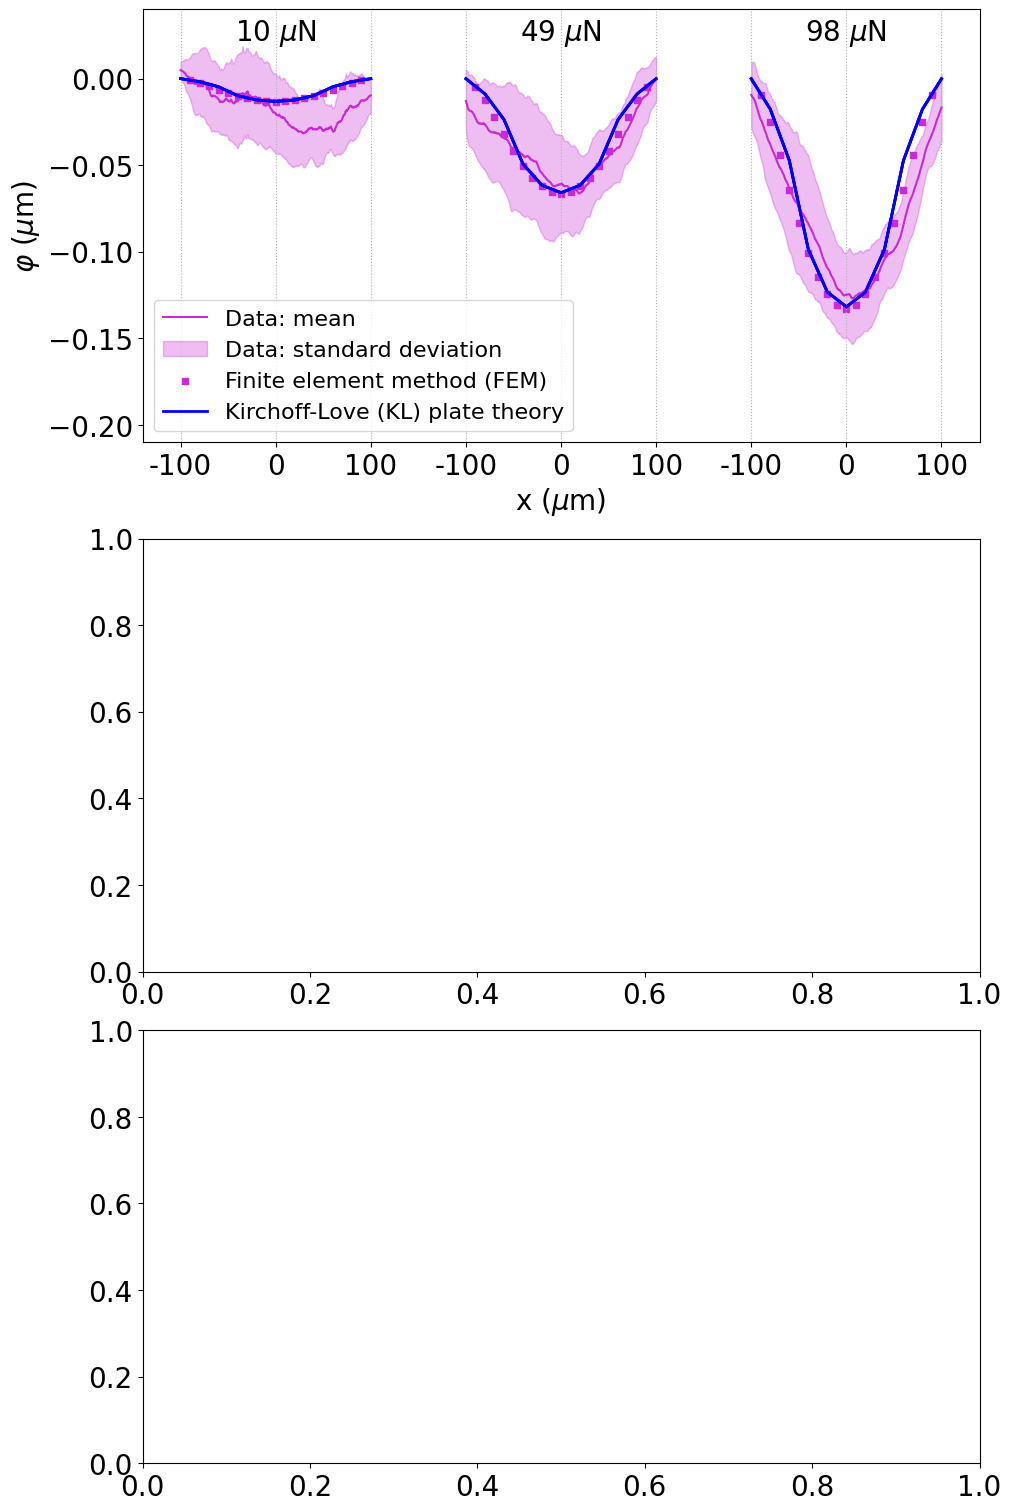

In [5]:
# Masses applied with the stylus (mg)
forces_waferA = np.arange(1, 16, 1) 
forces_waferB = np.arange(1, 16, 2) 

# Import Kirchhoff-Love plate theory data
num_pts = 200
x = np.linspace(0,200e-6,num_pts+1)
x_0 = x[::int(num_pts/10)]
x_0_plate_theory_wmin = np.loadtxt("Simulation_data/KL_profiles.txt")

# Finite element method (FEM) simulation data paths
sim_paths = [
    r"Simulation_data\FEM_simulation_1mg", 
    r"Simulation_data\FEM_simulation_5mg", 
    r"Simulation_data\FEM_simulation_10mg"
]

filesuffixes = ['01','05','10']
exp_data = result_waferA
pos_forces = [1, 5, 10]

# All subpanels of Fig 6 are initialized here (intended that only the first subpanel is filled by running this cell)
fig_deform, ax_deform = plt.subplots(3,1, figsize=(10,15), constrained_layout=True)
fig_deform.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2) 

ax_deform[0].cla()

for n in range(len(sim_paths)):
    sim_mem_profile(
        sim_paths[n], 
        filesuffixes[n], 
        exp_data, 
        pos_forces[n], 
        forces_waferA, 
        fig_deform, 
        ax_deform[0], 
        cnt=n       
    )

x_range = 100
x_offset_arr = [100, 400, 700]
x_offset_arr_interp = [[x-x_range,x,x+x_range] for x in x_offset_arr]
x_offset_arr_interp = np.reshape(x_offset_arr_interp, shape=(np.size(x_offset_arr_interp),))
x_labels_interp = [-x_range,0,x_range]*len(x_offset_arr)
ax_deform[0].set_xticks(x_offset_arr_interp, x_labels_interp)
ax_deform[0].grid(True, axis='x', linestyle=':')
ax_deform[0].set_xlabel('x ($\mu$m)')
ax_deform[0].set_ylabel(r'$\varphi$ ($\mu$m)')
ax_deform[0].set_ylim([-0.21, 0.04])


In [6]:
def extract_fem_plane(filename, forces, disp_idx=0, period=5, interp_method='cubic'):
    """
    Extracts the z-displacements from the quantum well upper Si/SiGe plane data exported from COMSOL.

    """
    displacement = []
    for ii, _ in enumerate(forces):
        data = np.genfromtxt(filename, comments='%')
        x = data[:,0]
        y = data[:,1]
        displacement.append(griddata((x, y), data[:,disp_idx + ii*period], ([0],[0]), method=interp_method))

    return displacement
    
forces = 9.8*np.array([2,4,6,8,10,12,14,15])
filename_waferA = "Simulation_data\FEM_simulation_QW_plane_10mg_waferA.txt"
filename_waferB = "Simulation_data\FEM_simulation_QW_plane_10mg_waferB.txt"

displacement_A = extract_fem_plane(filename_waferA, forces, disp_idx=7)
displacement_B = extract_fem_plane(filename_waferB, forces, disp_idx=3)

<>:16: SyntaxWarning: invalid escape sequence '\F'
<>:17: SyntaxWarning: invalid escape sequence '\F'
<>:16: SyntaxWarning: invalid escape sequence '\F'
<>:17: SyntaxWarning: invalid escape sequence '\F'
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\2480380369.py:16: SyntaxWarning: invalid escape sequence '\F'
  filename_waferA = "Simulation_data\FEM_simulation_QW_plane_10mg_waferA.txt"
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\2480380369.py:17: SyntaxWarning: invalid escape sequence '\F'
  filename_waferB = "Simulation_data\FEM_simulation_QW_plane_10mg_waferB.txt"


<>:3: SyntaxWarning: invalid escape sequence '\K'
<>:4: SyntaxWarning: invalid escape sequence '\K'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\K'
<>:4: SyntaxWarning: invalid escape sequence '\K'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\1884834060.py:3: SyntaxWarning: invalid escape sequence '\K'
  F_plate_theory_A = np.loadtxt("Simulation_data/KL_deflection_forces_waferA.txt")
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\1884834060.py:4: SyntaxWarning: invalid escape sequence '\K'
  F_plate_theory_B = np.loadtxt("Simulation_data/KL_deflection_forces_waferB.txt")
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\1884834060.py:37: SyntaxWarning: invalid escape sequence '\m'
  ax_deform[1].set_xlabel('$F$ ($\mu$N)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\1884

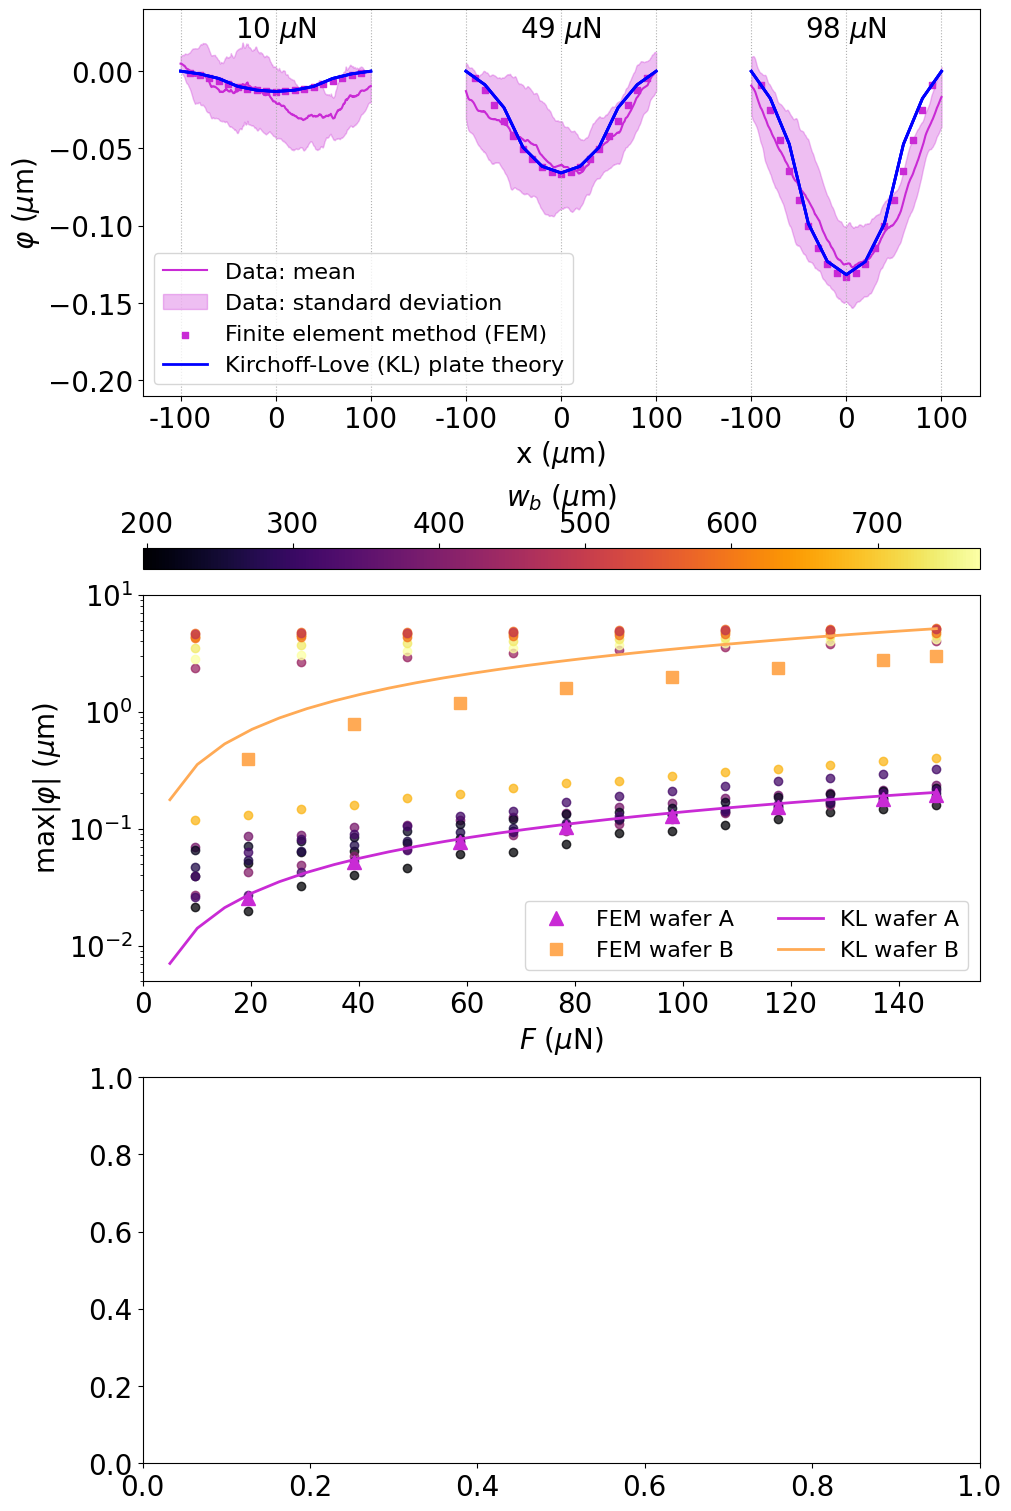

<Figure size 640x480 with 0 Axes>

In [7]:
# Import KL-plate theory results for different applied forces
F_plate_theory = F = 9.8 * np.linspace(0,15,30)     # muN
F_plate_theory_A = np.loadtxt("Simulation_data/KL_deflection_forces_waferA.txt")
F_plate_theory_B = np.loadtxt("Simulation_data/KL_deflection_forces_waferB.txt")

data_arr = [result_waferA, result_waferB]
forces_arr = [forces_newtons_waferA, forces_newtons_waferB]
mem_idxs = [wrong_idx, mem_idx]
example_idxs = [0,2]

# Plot maximum displacements (experimental data)
for jj, data in enumerate(data_arr):
    for ii, key in enumerate(data.keys()):
        width = data[key]["Widths"]["Forward"][0]
        widths = np.array([data_arr[n][m]["Widths"]["Forward"][0] for m in data_arr[jj].keys() for n in range(len(data_arr))])
        peaks = data[key]["Peaks"]["Forward"]
        color = colormap_range(widths, width, cmap)
        if jj==1 and ii==7: continue
        if jj==1: mfc = None 
        else: mfc = color
        ax_deform[1].plot(forces_arr[jj], 1e-4*np.abs(peaks), 
                 'o', linewidth=2, color=color, mfc=mfc, label=None, alpha=0.75)
        
# Plot FEM and KL data
sim_linewidth = 2
sim_markersize = 10
ax_deform[1].plot(forces, np.abs(displacement_A), '^', color=color_cycle[2], linewidth=sim_linewidth, 
         markersize=sim_markersize,
         label='FEM wafer A')
ax_deform[1].plot(forces, np.abs(displacement_B), 's', color=color_cycle[3], linewidth=sim_linewidth, 
         markersize=sim_markersize-2,
         label='FEM wafer B')
ax_deform[1].plot(F_plate_theory[1::], 1e6*np.abs(F_plate_theory_A[1::]), 
         color=color_cycle[2], linewidth=sim_linewidth, label='KL wafer A')
ax_deform[1].plot(F_plate_theory[1::], 1e6*np.abs(F_plate_theory_B[1::]), 
         color=color_cycle[3], linewidth=sim_linewidth, label='KL wafer B')
ax_deform[1].set_xlabel('$F$ ($\mu$N)')
ax_deform[1].set_ylabel(r'max$|\varphi|$ ($\mu$m)')
ax_deform[1].set_yscale('log')
ax_deform[1].legend(loc='lower right', fontsize=legend_fs, ncols=2)
ax_deform[1].set_ylim([5e-3, 1e1])
ax_deform[1].set_xlim([0,155])

sm_2 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(widths), vmax=np.max(widths)))
cbar_2 = plt.colorbar(sm_2, pad=0.035, ax=ax_deform[1], orientation='horizontal', location='top', aspect=40)
cbar_2.ax.set_xlabel('$w_b$ ($\mu$m)')

display(fig_deform)

In [8]:
def anisotropic_coefficients(C_11, C_12, C_44, theta, t_m):
    """
    Calculates the elastic coefficients for arbitrary in-plane (xy) directions in an elastically anistropic 
    material with cubic symmetry (such as silicon).
    Also calculates the flexural rigidity (bending stiffness) which depends on the membrane thickness.

    Arguments: 
        C_11, C12, C44 :        Elastic constants in cubic crystallographic frame (x,y,z along [100],[010],[001]) (Pa)
        theta :                   Rotation angle
        H :                     Membrane thickness  

    Returns generalized anistropic flexural rigidity : D_ani = D_iso / (t_m)^3 (1 + 2*k_2 + k_4)
    """

    # Stiffness tensor (in Pa)
    C = np.array([
        [C_11, C_12, 0],
        [C_12, C_11, 0], 
        [0, 0, C_44]
    ])

    # Compliance tensor
    S_eff_cubic = np.linalg.inv(C)

    # Rotation matrix
    R = np.array([
        [np.cos(theta), np.sin(theta), 0], 
        [-np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

    # Rotation prefactor
    Delta = np.array([
        [(np.cos(4*theta)-1)/4, (1-np.cos(4*theta))/4, -np.sin(4*theta)/2], 
        [(1-np.cos(4*theta))/4, (np.cos(4*theta)-1)/4, np.sin(4*theta)/2],
        [-np.sin(4*theta)/2, np.sin(4*theta)/2, (1-np.cos(4*theta))]
    ])

    # Compliance tensor in rotated frame
    S_eff = S_eff_cubic + (S_eff_cubic[0,0] - S_eff_cubic[1,0] - S_eff_cubic[2,2]/2) * Delta

    # Anisotropic flexural rigidity coefficients 
    k_2 = (4*S_eff[0,0]*S_eff[1,1] - 2*S_eff[1,0]*(2*S_eff[1,0] + S_eff[2,2])) / (S_eff[1,1]*S_eff[2,2])
    k_4 = S_eff[0,0] / S_eff[1,1]

    # Isotropic flexural rigidity in rotated fram 
    D_iso = t_m**3 / 12 * S_eff[1,1] / (S_eff[0,0]*S_eff[1,1] - S_eff[1,0]**2)

    return k_2, k_4, D_iso, S_eff

# Test
C_11 = 165.64e9
C_12 = 63.94e9
C_44 = 79.51e9
phi = np.pi/4
t_m = 2.4e-6
k_2, k_4, D_iso, S_eff = anisotropic_coefficients(C_11, C_12, C_44, phi, t_m)



In [9]:
from scipy.special import jv
from scipy.sparse import diags, kron, identity, csr_matrix
from scipy.sparse.linalg import spsolve

def M_biax(x):
    """
    Calculates biaxial modulus for Si_{1-x}Ge_{x}
    """
    # along [100]
    E = (130.2 - 28.1*x) * 1e9
    nu = 0.278 - 0.005*x
    return E / (1-nu)

def delta2_Neumann(Nx, dx):
    """
    5-point finite difference stencil for 2nd derivative 
    """
    D2x = diags([-1, 16, -30, 16, -1], 
                offsets=[-2, -1, 0, 1, 2], 
                shape=(Nx, Nx),
                format='csr') / (12*dx**2)
    D2x[0] = csr_matrix(np.array([-31, 16, -1] + [0] * (Nx - 3)) / (12*dx**2))
    D2x[-1] = csr_matrix(np.array([0] * (Nx - 3) + [-1, 16, -31]) / (12*dx**2))
    return D2x 

def delta4_Neumann(Nx, dx):
    """
    5-point finite difference stencil for 4th derivative 
    """
    D4x = diags([1, -4, 6, -4, 1], 
                offsets=[-2, -1, 0, 1, 2], 
                shape=(Nx, Nx),
                format='csr') / dx**4
    D4x[0] = csr_matrix(np.array([7, -4, 1] + [0] * (Nx - 3)) / dx**4)
    D4x[-1] = csr_matrix(np.array([0] * (Nx - 3) + [1, -4, 7]) / dx**4)
    return D4x 

def laplacian_2d(Nx, Ny, dx):
    """ 
    5-point finite difference stencil for 2D Laplacian
    """        
    D = delta2_Neumann(Nx, dx)
    I = identity(Nx)
    Lap_2D = kron(I, D) + kron(D, I)  # Combines rows and columns
    return Lap_2D


def anisotropic_bi_laplacian_2d(Nx, Ny, dx, dy):
    """ 
    5-point finite difference stencil for biharmonic operators
    """
    # 1D fourth-derivative stencils
    D4x = delta4_Neumann(Nx, dx)
    D4y = delta4_Neumann(Ny, dy)
    
    D2x = delta2_Neumann(Nx, dx)
    D2y = delta2_Neumann(Ny, dy)
    D2xy = kron(D2x, D2y)  # Mixed derivative
    
    # Full 2D operators
    Lxx = kron(identity(Ny), D4x)  # \partial^4 / \partial x^4
    Lyy = kron(D4y, identity(Nx))  # \partial^4 / \partial y^4
    Lxy = D2xy                     # \partial^4 / \partial x^2 \partial y^2
    
    return Lxx, Lyy, Lxy


def kirchoff_love_plate_finite_diff(w_b_x=200e-6, w_b_y=200e-6, t_m=2.41e-6, 
                                    F=-10e-6 * 9.8, 
                                    R=np.sqrt(np.pi * (2e-6)**2) / 2, 
                                    x_0=100e-6, y_0=100e-6, eps_biax=1.13e-2,
                                    num_pts=100):  
    """
    Computes the membrane deflection phi using the 2nd order finite difference method to solve the 
    Kirchhoff-Love equations in the presence of an external normal load and a initial in-plane strain.
    Membrane deflection is referenced with respect to the midplane of the membrane. 
    Note that due to the deflections involved, the difference between the displacement at the midplane and 
    at the surface of the membrane (along which the profilometer measures) is negligible.

    Arguments: 
        w_b_x, w_b_y :          Membrane widths along x,y (um)
        t_m :                   Membrane thickness (um)
        F :                     Applied force normal to the membrane (N)
        R :                     Radius of the contact area of the applied load (m^2)
        eps_biax :              Initial in-plane strain 
        num_pts :               Resolution along one axis of the grid
    """
    
    # Finite difference grid
    x = y = np.linspace(-w_b_x/2,w_b_x/2,num_pts)
    X,Y = np.meshgrid(x,y)
    X = X[:,:,None,None]
    Y = Y[:,:,None,None]

    # Convert load to Pa
    q = F / (np.pi*R**2)     

    # Isotropic elastic constants for Si70Ge30
    C_11 = (165.8 - 37.3*0.3)*1e9
    C_12 = (63.9 - 15.6*0.3)*1e9
    C_44 = (79.6 - 12.8*0.3)*1e9

    # Calculate anisotropic elastic constants along [110]
    theta = np.pi/4
    k_2, k_4, D_iso, _ = anisotropic_coefficients(C_11, C_12, C_44, theta, t_m)
    D_xx = D_iso
    D_xy = D_iso * k_2
    D_yy = D_iso * k_4

    # Convert intial strain to stress resultant
    h_Si = 10e-9            # Quantum well thickness (m)
    M_Si = M_biax(0)        # Si biaxial modulus [100]
    M_SiGe = M_biax(0.3)    # Si70Ge30 biaxial modulus [100]
    N_biax = eps_biax * M_SiGe * t_m * M_Si*h_Si /  ( M_SiGe*t_m + M_Si*h_Si )  # Stress resultant
    
    # Compute finite difference operators
    dx, dy = w_b_x / (num_pts - 1), w_b_y / (num_pts - 1)
    Lap_2D = laplacian_2d(num_pts, num_pts, dx)
    Lxx, Lyy, Lxy = anisotropic_bi_laplacian_2d(num_pts, num_pts, dx, dy)
    
    # Left/right-hand side of KL equation
    LHS = D_xx*Lxx + D_yy*Lyy + 2*D_xy*Lxy + N_biax * Lap_2D
    RHS = q.reshape((num_pts**2,))

    # Solve KL equation
    phi = spsolve(LHS, RHS)
    phi = phi.reshape((num_pts, num_pts)) 

    X = np.squeeze(X)
    Y = np.squeeze(Y)
        
    return X, Y, phi


In [10]:
mem_geo_space = np.loadtxt("Simulation_data/KL_elastic_modes.txt")  # Load pre-computed data, otherwise calculate with function in previous cell
w_b_arr = 1e-6*np.linspace(50, 450, 150)            # Membrane widths (m)
t_m_arr = 1e-6 * np.logspace(-0.5, 1, 150)          # Membrane thicknesses (m)    
M_SiGe = M_biax(0.3)                                # Si70Ge30 biaxial modulus
M_Si = M_biax(0)                                    # Si biaxial modulus
t_QW = 10e-9                                        # Quantum well thickness (m)
eps_biax = 1.13e-2                                  # Initial epitaxial strain in Si quantum well

ax_deform[2].cla()

X_plot, Y_plot = np.meshgrid(t_m_arr, w_b_arr)
mem_geo_space[mem_geo_space==0.0] = 1e-28  # Zeros lead to (numerical artefact) patches in plot along buckling mode lines

# Plot results
buckle_plot = ax_deform[2].pcolormesh(1e6*X_plot, 1e6*Y_plot, 1e6*np.abs(mem_geo_space), 
               norm='log', shading='gouraud', vmin=2e-4, vmax=1e3)

# Calculate anistropic elastic coefficients for Si70Ge30 along [110]
C_11 = (165.8 - 37.3*0.3)*1e9   # Pa
C_12 = (63.9 - 15.6*0.3)*1e9    # Pa
C_44 = (79.6 - 12.8*0.3)*1e9    # Pa
phi = np.pi/4                   # rad
D_ani_g = np.zeros((len(t_m_arr,)))
for ii, t_m in enumerate(t_m_arr):
    k_2, k_4, D_a, _ = anisotropic_coefficients(C_11, C_12, C_44, phi, t_m)
    D_xx = D_a
    D_xy = D_a * k_2
    D_yy = D_a * k_4
    # Generalized anistropic flexural rigidity
    D_ani_g[ii] = (D_xx + 2*D_xy + D_yy) / t_m**3     

# Calculate and plot theoretical critical in-plane stress for appearance of first buckling mode
sigma_biax = eps_biax * M_SiGe * M_Si*t_QW /  ( M_SiGe*t_m_arr + M_Si*t_QW )    
w_b_cr = np.sqrt(D_ani_g / sigma_biax) * (np.pi * t_m_arr) 
ax_deform[2].plot(1e6*t_m_arr, 1e6*w_b_cr, 'k--', linewidth=3, label=r'$\sigma_{\text{cr}} \propto (t_m / w_b)^2$')

# Import measured geometries 
t_A_mean, t_A_err, w_b_A_mean, w_b_A_err, t_B_mean, t_B_err, w_b_B_mean, w_b_B_err = np.loadtxt("measured_geometries.txt") 

ax_deform[2].set_xscale('log')
color_A = 'w'
color_B = 'w'
# ax_deform[2].scatter(2.41, 200, s=200, c=color_A)
ax_deform[2].errorbar(t_A_mean, w_b_A_mean, xerr=t_A_err, yerr=w_b_A_err, color=color_A, marker='o', ms=16, capsize=5)
ax_deform[2].text(t_A_mean, w_b_A_mean, 'A', c='k', ha='center', va='center', fontsize=13, fontweight='bold')
ax_deform[2].errorbar(t_B_mean, w_b_B_mean, xerr=t_B_err, yerr=w_b_B_err, color=color_B, marker='o', ms=16, capsize=5)
# ax_deform[2].scatter(1.37, 300, s=200, c=color_B)
ax_deform[2].text(t_B_mean, w_b_B_mean, 'B', c='k', ha='center', va='center', fontsize=13, fontweight='bold')
ax_deform[2].set_ylim([50,450])
ax_deform[2].set_xlim([1e6*np.min(t_m_arr),1e6*np.max(t_m_arr)])
cbar = fig_deform.colorbar(buckle_plot, pad=0.035, ax=ax_deform[2], orientation='horizontal', location='top', aspect=40)
cbar.ax.set_xlabel(r'$\max\left(|\varphi|\right)$ ($\mu$m)')
ax_deform[2].set_xlabel('$t_m$ ($\mu$m)')
ax_deform[2].set_ylabel('$w_b$ ($\mu$m)')
ax_deform[2].legend(loc='upper right')

buckle_plot.set_rasterized(True)
plt.rcParams['svg.fonttype'] = 'none'

<>:1: SyntaxWarning: invalid escape sequence '\K'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\K'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\3427015495.py:1: SyntaxWarning: invalid escape sequence '\K'
  mem_geo_space = np.loadtxt("Simulation_data/KL_elastic_modes.txt")  # Load pre-computed data, otherwise calculate with function in previous cell
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\3427015495.py:53: SyntaxWarning: invalid escape sequence '\m'
  ax_deform[2].set_xlabel('$t_m$ ($\mu$m)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_23860\3427015495.py:54: SyntaxWarning: invalid escape sequence '\m'
  ax_deform[2].set_ylabel('$w_b$ ($\mu$m)')


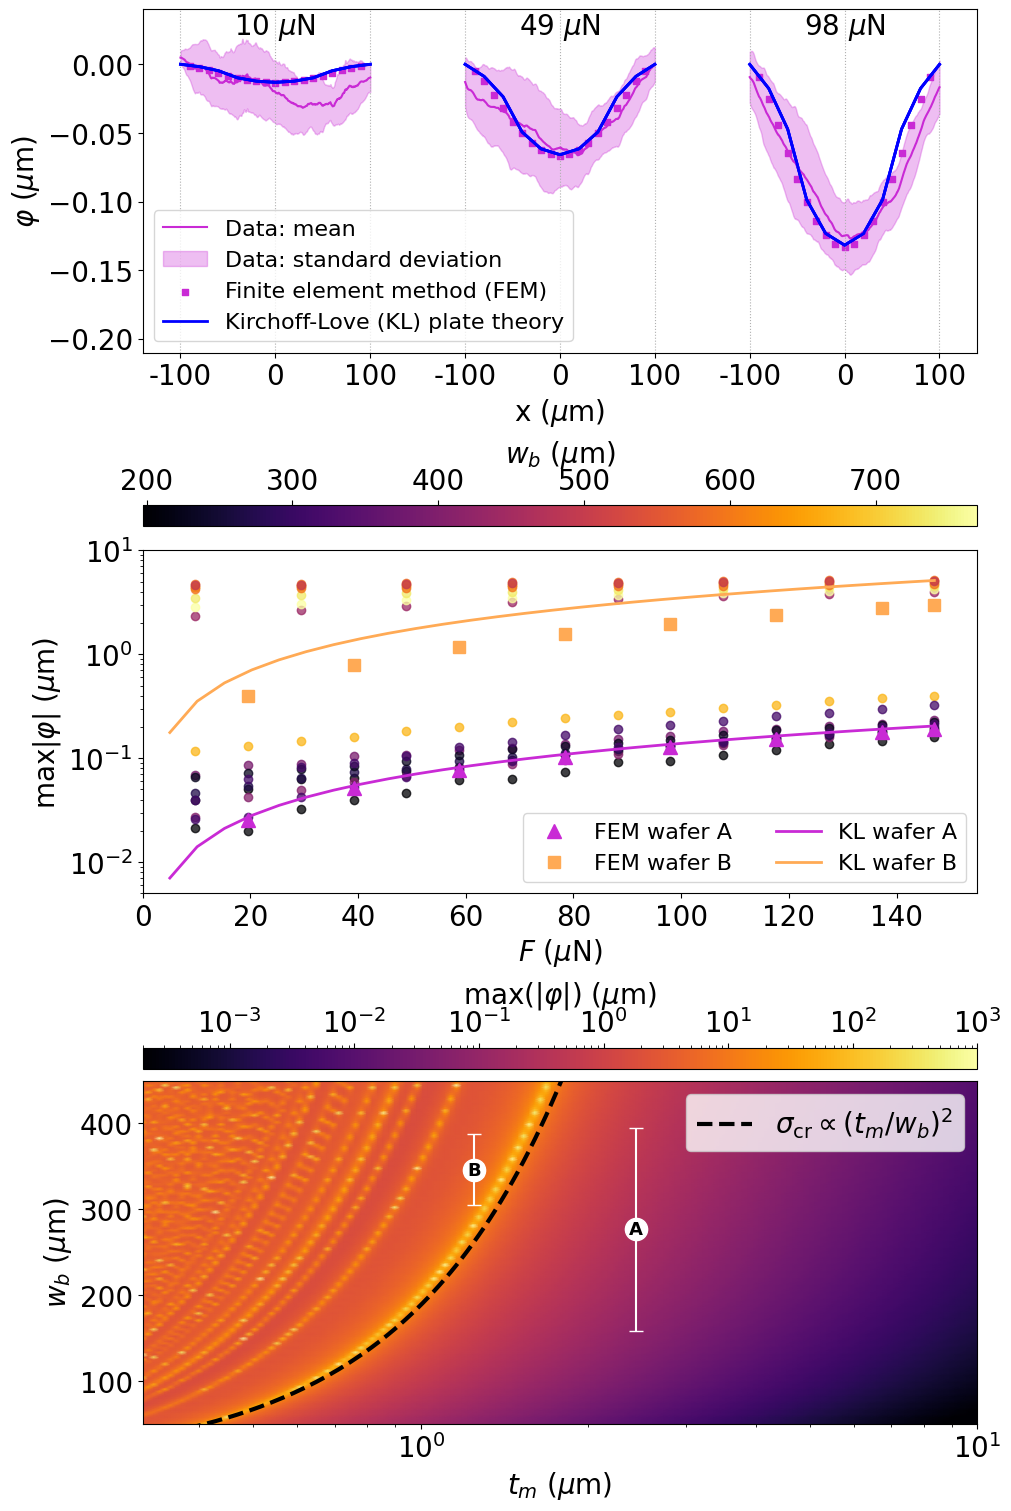

In [11]:
display(fig_deform)